# TDT05 Classification - Challenge 2

## Team: 5_AI-gutta

- Magnus Schjølberg     
- Nicklas Bekkevold

## Table of contents
1. Table of contents
2. Imports and loading the data 
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Data Cleaning
6. Model Choice and Training
7. Prediction
8. Model Interpretation

# Imports and loading the data

In [308]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

from catboost import CatBoostClassifier, CatBoostRegressor, metrics
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import ConfusionMatrixDisplay


print('Tensorflow version:', tf.__version__)

# Config
rcParams['figure.figsize'] = 20, 10  # Make plots bigger
RANDOM_SEED = 42  # For reproducibility

Tensorflow version: 2.6.0


In [309]:
# Loading the data
training_data = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_train.csv', index_col=0)
X_test = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_test.csv', index_col=0)

print('Training shape:', training_data.shape)
print('Test shape:', X_test.shape)
summary_statistics = pd.DataFrame(
    {
        'dtype': training_data.dtypes,
        'categories': training_data.nunique(),
        '#nan': training_data.isnull().sum(axis = 0),
    }, 
    index=training_data.columns,
)

print(summary_statistics)
training_data.head(5)

Training shape: (50000, 30)
Test shape: (50000, 29)
          dtype  categories   #nan
target    int64           2      0
f0      float64           2   1459
f1       object         190   1487
f2       object           6   1439
f3      float64           3   1488
f4       object           2   1498
f5      float64          13  11617
f6      float64           2   1490
f7      float64           6   1525
f8       object        2177   1490
f9       object           5   1489
f10      object          26   1501
f11     float64        7633    145
f12      object         222   1541
f13      object          15   1447
f14      object        1204   1451
f15      object         222   1477
f16     float64          12   1460
f17     float64       19209   9762
f18      object           6   1556
f19     float64           6   1437
f20     float64           4   1464
f21     float64           7   1510
f22      object           3   1513
f23      object        1495   1516
f24     float64        4148   2696
f25

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,gL,e,3.0,A,NaN,0.0,6.0,96ae67d3e,...,0.5,0.0,3.0,R,328b0cf4e,0.834041,T,N,1.0,14.2364
1,0,0.0,Rj,c,1.0,A,7.0,1.0,4.0,9fcf422f2,...,0.4,0.0,1.0,NaN,328b0cf4e,0.686021,T,N,1.0,NaN
2,0,NaN,In,a,1.0,A,10.0,1.0,6.0,a5adff44e,...,0.5,1.0,3.0,G,0c67fcbbd,1.141271,T,N,3.0,NaN
3,1,1.0,rA,c,3.0,A,7.0,1.0,1.0,15c90ab2e,...,0.6,1.0,1.0,G,fee4e3007,0.662382,T,N,3.0,NaN
4,0,1.0,pE,c,3.0,A,7.0,0.0,6.0,b36490559,...,0.5,0.0,1.0,B,587e040bd,-1.000000,T,N,1.0,13.9537


# Exploratory Data Analysis (EDA)

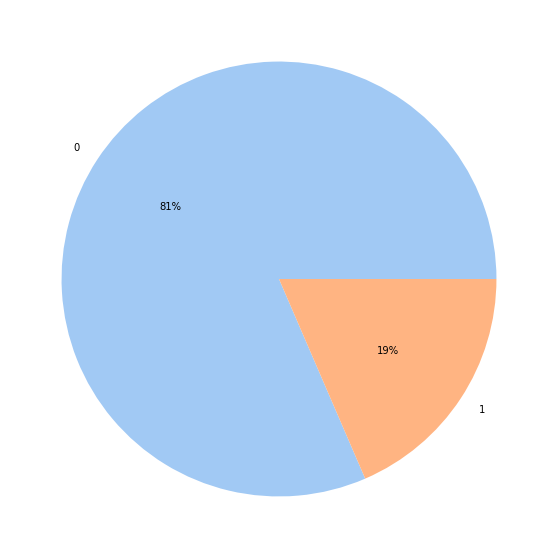

In [310]:
plt.pie(
    training_data['target'].value_counts(), 
    colors=sns.color_palette('pastel')[0:2], 
    labels=['0', '1'],
    autopct='%.0f%%',
)
plt.show()

The target value is 0 or 1, indicating that the task to solve is binary classification.  
There is a lot more of the 0-class (81%) than the 1-class (19%).

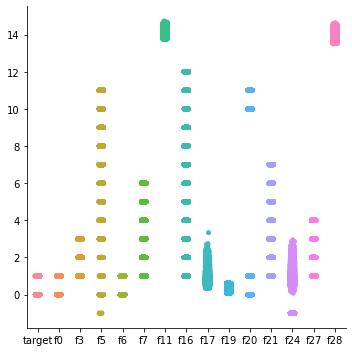

In [311]:
sns.catplot(data=training_data)
plt.show()

It is interesting to see that several of the features has "-1" as a value. This might be an explicit na / null-value set by a user or something similar.  

## Plot feature distributions

We plot all the features to get a feel for the different features.  

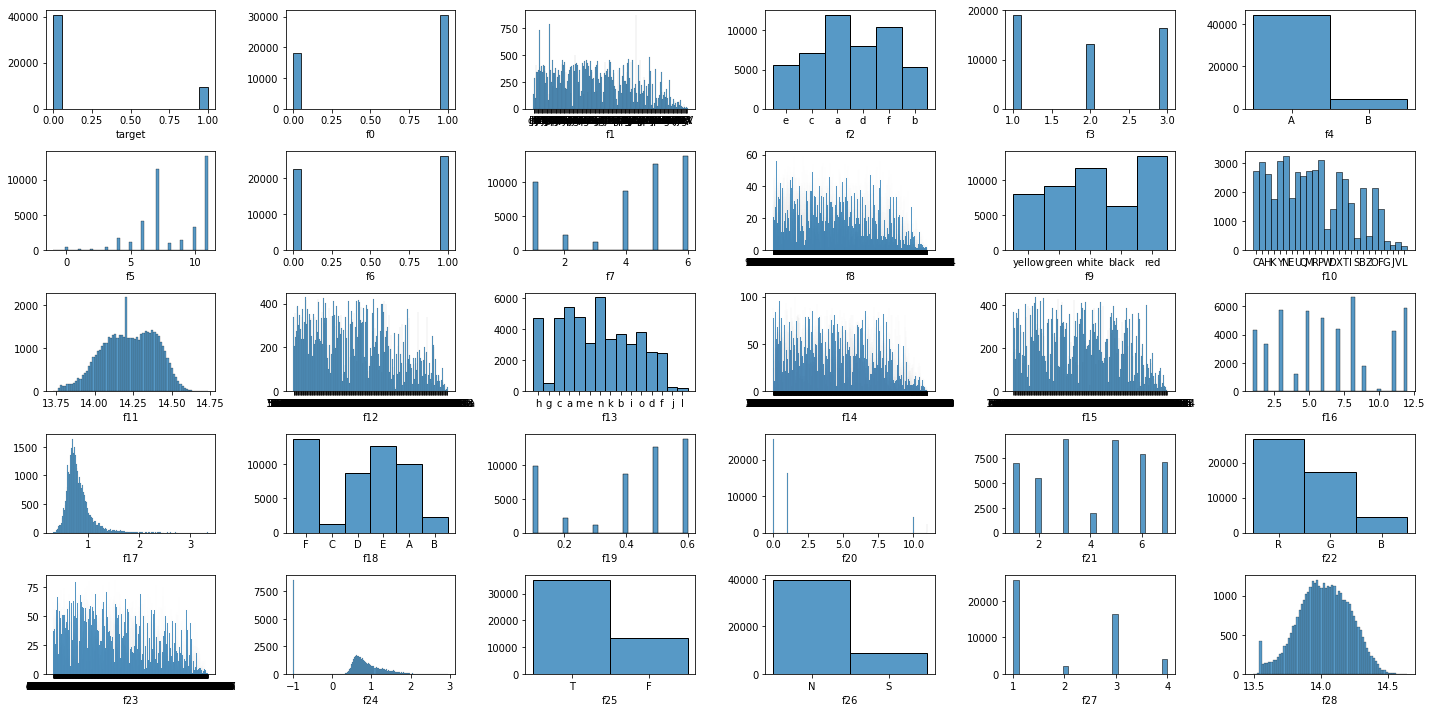

In [312]:
# Plot all features to see their shape
fig, axes = plt.subplots(5, 6)

for i, feature in enumerate(list(training_data.columns)):
    ax = sns.histplot(training_data[feature], ax=axes[i // 6][i % 6])
    ax.set_xlabel(feature)
    ax.set_ylabel('')

fig.tight_layout()
plt.show()

## Feature description

Each feature is listed below with some example values and our notes.  
We have also grouped each feature into categories based on similarities to make preprocessing easier.  
(We also used Kaggle's built in data explorer and Excel to take a look at the features.)

| Feature | Example | Our feature "category" | Note |
| :-- | :-- | :-- | :-- |
| target | 0 or 1 | boolean | This means that the problem is a binary classification |
| f0 | 0.0 or 1.0 | boolean | Could be turned into a categorical feature |
| f1 | gL, Rj, In, ... | categorical | 173 unique two letter pairs, could be country codes or something similar |
| f2 | a, b, ..., f | alphabetic | letters a-f |
| f3 | 1.0, 2.0 or 3.0 | ordinal | ordinal of some kind, should not be converted to categorical |
| f4 | A or B | boolean | mostly As (=88%) |
| f5 | -1, 0, ..., 11 | ordinal | weird distribution, many null values |
| f6 | 0 or 10 | binary | Binary - could be turned into a categorical feature |
| f7 | 1, 2, ..., 6 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f8 | '96ae67d3e', 'a5adff44e' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f9 | red, white, black, green, yellow | categorical | five colors |
| f10 | A, B, ..., Z | alphabetic | Could be converted to integers to get ordinal property |
| f11 | 139681, 140242 | interval |
| f12 | '1c756c04a', '5d1ac7760' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f13 | a, b, ..., o | alphabetic | Could be converted to integers to get ordinal property |
| f14 | '168e51823', '558613041' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f15 | '7861df0a8', '1d88b0a79' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f16 | 0, 10, ..., 120 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f17 | 858314945, 616742978 | interval |  |
| f18 | A, B, ..., F | alphabetic | Could be converted to integers to get ordinal property |
| f19 | 0, 1, ..., 6 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f20 | 00, 01, 10 or 11 | binary | Looks like a binary number. Could be converted to 0, 1, 2 and 3 |
| f21 | 0, 10, ..., 70 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f22 | R, G or B | categorical | Could it be a coincidence that it is RGB? |
| f23 | '328b0cf4e', '0c67fcbbd' | hexadecimal | Looks like hexadecimal, might be a hash of some kind |
| f24 | 834041366, 686021137 | interval |  |
| f25 | T or F | Boolean | Boolean - (T)rue or (F)alse |
| f26 | N or S | Boolean | Boolean - (N)orth or (S)outh? |
| f27 | 1, 2, ..., 4 | ordinal | Ordinal of some kind, should not be converted to categorical |
| f28 | 141855, 139805 | interval |  |


## Feature mean distribution

Check if there is any noticeable groupings in the feature means.

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


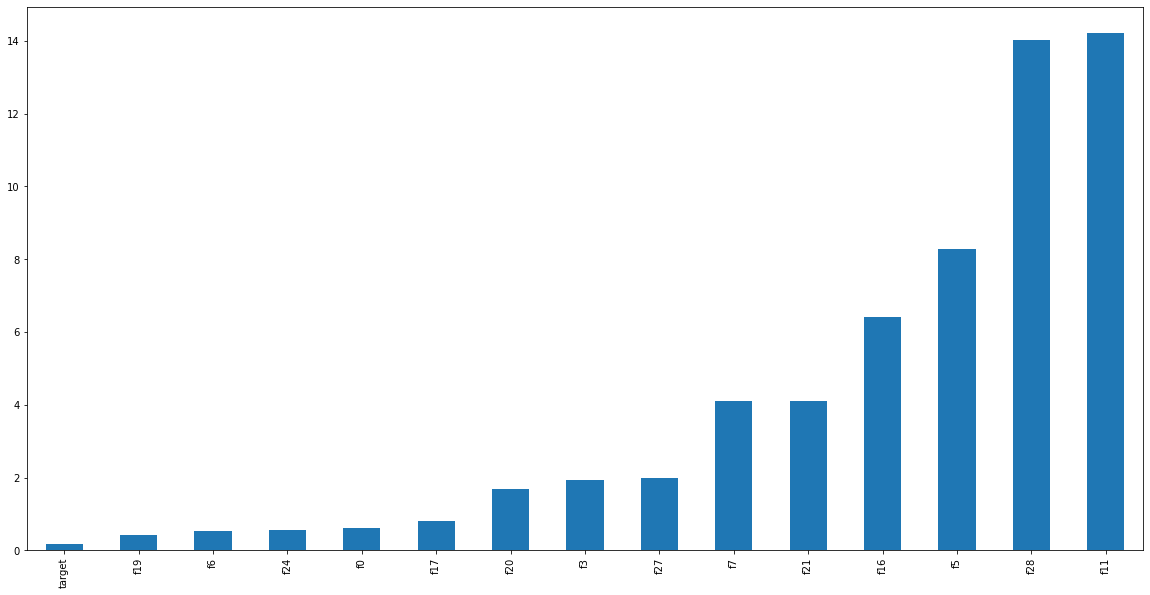

In [313]:
# Plot mean per feature 
training_data.mean(axis=0).sort_values().plot(kind='bar')
plt.show()

Feature f11 and f28 have similar mean values. Let's see if they are correlated.

## Correlation plot

See if there are any interesting patterns in the data.

In [314]:
# Plot correlations using the pearson method
categorical_encoder = lambda x : pd.factorize(x)[0]  # Encodes categorical data for correlation plot 
encoded_training_data = training_data.apply(categorical_encoder)

correlation = encoded_training_data.corr(method='pearson', min_periods=1)
correlation.style.background_gradient(cmap='viridis').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`


,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
target,1.00,0.00,0.00,0.01,-0.05,-0.05,-0.01,-0.02,0.03,0.00,-0.04,0.02,-0.01,0.01,0.05,0.00,-0.00,0.04,-0.01,0.05,-0.01,0.00,0.03,0.01,-0.00,-0.00,0.06,-0.02,0.00,-0.00
f0,0.00,1.00,-0.00,0.00,-0.01,0.00,-0.00,0.00,0.00,0.01,0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,0.01
f1,0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.01,-0.01,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,0.00,-0.00,0.00,-0.02,0.00,0.01
f2,0.01,0.00,0.00,1.00,-0.00,0.01,-0.01,0.01,0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.01,-0.00,0.00,0.01,-0.00,0.01,0.00,0.00,-0.00,-0.00
f3,-0.05,-0.01,-0.00,-0.00,1.00,0.01,0.01,-0.01,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.01,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00
f4,-0.05,0.00,-0.00,0.01,0.01,1.00,0.00,0.01,-0.00,0.00,0.01,-0.00,0.01,-0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01
f5,-0.01,-0.00,-0.01,-0.01,0.01,0.00,1.00,-0.00,0.00,0.01,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,0.01,0.00,-0.00,0.01,0.00,0.00,-0.01,0.03,-0.00,-0.00,0.01,-0.01
f6,-0.02,0.00,-0.00,0.01,-0.01,0.01,-0.00,1.00,0.01,0.00,0.01,0.00,0.00,0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.00,-0.00,-0.00,0.01,0.00,0.00,0.00
f7,0.03,0.00,0.00,0.00,0.00,-0.00,0.00,0.01,1.00,0.00,-0.01,0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,0.01,-0.00,-0.00,-0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
f8,0.00,0.01,0.01,-0.01,-0.00,0.00,0.01,0.00,0.00,1.00,0.00,0.00,0.04,0.00,-0.01,0.02,0.00,0.00,0.03,0.01,0.01,-0.01,-0.00,-0.00,0.02,0.03,-0.00,-0.00,-0.01,0.03


f11 and f28 does not have a significant correlation, but they might be related in some other way.  
However, f20 and f27 have a very high correlation using the *pearson* method. The other feature pairs seem quite uncorrelated.

## Check if the dataset is shuffled

To check if the dataset is shuffled or have any trends we use the *rolling mean* for three features: f17, f24, and f28.

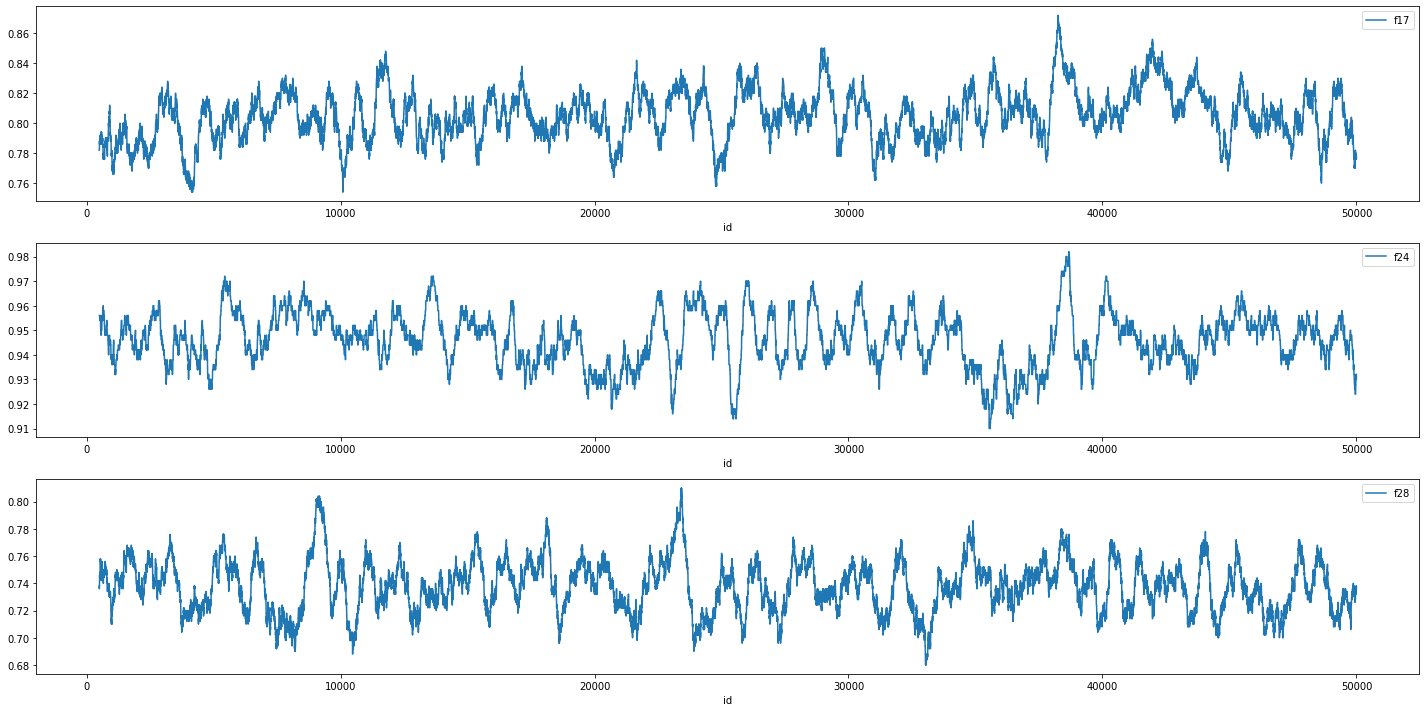

In [315]:
# Make rolling mean plot
features = ['f17', 'f24', 'f28']
fig, axes = plt.subplots(len(features), 1)

for i, feature in enumerate(features):
    training_data[feature].notna().rolling(window=500).mean().plot(ax=axes[i], legend=feature)

plt.tight_layout()
plt.show()

The data seems to be randomly distributed, i.e. it does not show any noticeable patterns. 

## Explore the hexadecimal features

The features labeled:
- f8 
- f12 
- f14 
- f15 
- f23

All seem to be hexadecimal. These might just be an id of sorts, or anonymized words, or they can be the hex representation of a number.  
An idea can be to covert these into decimal and see if they are important somehow.

Or check if the number of categories increases significantly when we add the test data.

In [316]:
# Check if the number of categories increases when we add the test data 
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']
merged_datasets = pd.concat([training_data, X_test])[hexadecimal_features]

merged_statistics = pd.DataFrame(
    {
        '#categories before merge': training_data.nunique(), 
        '#categories after merge': merged_datasets.nunique(),
        'increase': merged_datasets.nunique() - training_data.nunique(),
    }, 
    index=merged_datasets.columns,
)

print(merged_statistics)

     #categories before merge  #categories after merge  increase
f8                       2177                     2203      26.0
f12                       222                      222       0.0
f14                      1204                     1211       7.0
f15                       222                      222       0.0
f23                      1495                     1514      19.0


# Feature engineering

By encoding some of the categorical features, we might be able to see some patterns more clearly and improve the correlation analysis.  
It might also be useful for predictors who only accepts numeric values.

In [317]:
# Make a copy of the data to have both versions available
encoded_training_data = training_data.copy()
X_test_encoded = X_test.copy()

## Convert hexadecimal values to decimal

In [318]:
# Convert hexadecimal numbers to decimal
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']

hexadecimal_to_decimal = lambda hexadecimal: int(hexadecimal, base=16)
encoded_training_data[hexadecimal_features] = encoded_training_data[hexadecimal_features].applymap(hexadecimal_to_decimal, na_action='ignore')
X_test_encoded[hexadecimal_features] = X_test_encoded[hexadecimal_features].applymap(hexadecimal_to_decimal, na_action='ignore')

encoded_training_data[hexadecimal_features].astype(float)
encoded_training_data[hexadecimal_features].astype(float)


,f8,f12,f14,f15,f23
id,,,,,
0,4.044820e+10,7.639319e+09,6.054812e+09,3.231488e+10,1.356758e+10
1,4.289856e+10,2.499258e+10,2.295760e+10,7.927958e+09,1.356758e+10
2,4.447430e+10,6.477617e+10,4.672960e+10,4.916987e+10,3.330264e+09
3,5.847952e+09,2.330708e+10,3.618506e+10,4.454242e+10,6.842261e+10
4,4.815540e+10,2.312208e+10,1.325698e+10,3.231488e+10,2.375446e+10
...,...,...,...,...,...
49995,2.142359e+10,1.438836e+10,3.557118e+10,8.557800e+09,3.081632e+10
49996,3.853981e+10,8.017118e+09,5.113835e+10,3.729026e+10,9.947752e+09
49997,1.914109e+10,9.014997e+09,4.397755e+10,5.715447e+09,4.577327e+09


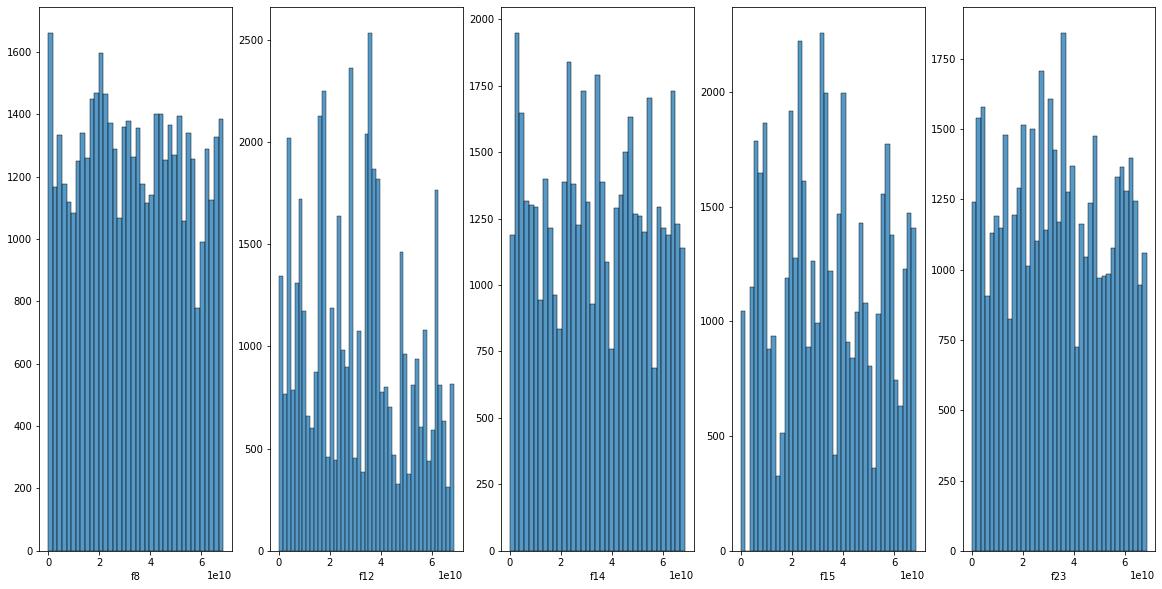

In [319]:
# Plot distribution
# See if there are some patterns in the hexadecimal features if converted to decimal numbers 
fig, axes = plt.subplots(1, len(hexadecimal_features))

for i, feature in enumerate(hexadecimal_features):
    ax = sns.histplot(encoded_training_data[feature], ax=axes[i])
    ax.set_xlabel(feature)
    ax.set_ylabel('')

plt.show()

## Convert binary numbers to decimal

In [320]:
# Convert binary numbers to decimal
binary_features = ['f20']  # 'f6' is automatically converted by pandas

binary_to_decimal = { 
    0.0: 0, 
    1.0: 1,
    10.0: 2,
    11.0: 3 
}

encoded_training_data[binary_features[0]] = encoded_training_data[binary_features[0]].map(binary_to_decimal, na_action='ignore')
X_test_encoded[binary_features[0]] = X_test_encoded[binary_features[0]].map(binary_to_decimal, na_action='ignore')

encoded_training_data[binary_features[0]].astype(float)
X_test_encoded[binary_features[0]].astype(float)

print(encoded_training_data[binary_features[0]].unique())

[ 0.  1.  2.  3. nan]


## Convert alphabetic characters to numbers

In [321]:
# Convert alphabetic characters to numbers: A=0, B=1, ..., Z=25
alphabetic_features = ['f2', 'f10', 'f13', 'f18']

alphabetic_to_ordinal = lambda c: ord(c.lower()) - 97
encoded_training_data[alphabetic_features] = encoded_training_data[alphabetic_features].applymap(alphabetic_to_ordinal, na_action='ignore')
X_test_encoded[alphabetic_features] = X_test_encoded[alphabetic_features].applymap(alphabetic_to_ordinal, na_action='ignore')

encoded_training_data[alphabetic_features].astype(float)
X_test_encoded[alphabetic_features].astype(float)

,f2,f10,f13,f18
id,,,,
50000,5.0,17.0,13.0,4.0
50001,5.0,24.0,13.0,4.0
50002,4.0,20.0,3.0,5.0
50003,NaN,8.0,7.0,0.0
50004,4.0,10.0,13.0,4.0
...,...,...,...,...
99995,5.0,15.0,0.0,4.0
99996,0.0,13.0,12.0,4.0
99997,5.0,13.0,14.0,4.0


## Convert boolean features to numbers

In [322]:
# Convert boolean features to 0.0 and 1.0
boolean_mappings = {
    'f4': {'B': 0.0, 'A': 1.0},
    'f25': {'F': 0.0, 'T': 1.0},
    'f26': {'S': 0.0, 'N': 1.0},
}

boolean_features = boolean_mappings.keys()

for feature, mapping in boolean_mappings.items():
    encoded_training_data[feature] = encoded_training_data[feature].map(mapping, na_action='ignore')
    X_test_encoded[feature] = X_test_encoded[feature].map(mapping, na_action='ignore')
    
    encoded_training_data[feature].astype(float)
    X_test_encoded[feature].astype(float)

## Decrement f3, f7, and f27 by one

- f3 ranges from 1-3
- f4 ranges from 1-6
- f27 ranges from 1-4

We shift their scales down by one to make then more comparable to other features which start at 0

In [323]:
# Decrement features by one
features = ['f3', 'f7', 'f27']
decrement_by_one = lambda number: number - 1

encoded_training_data[features] = encoded_training_data[features].applymap(decrement_by_one, na_action='ignore')
encoded_training_data[features].head()

,f3,f7,f27
id,,,
0,2.0,5.0,0.0
1,0.0,3.0,0.0
2,0.0,5.0,2.0
3,2.0,0.0,2.0
4,2.0,5.0,0.0


## Correlation plot for encoded training data

Plot with encoded values to look for correlation across *nearly* all features.

<AxesSubplot:>

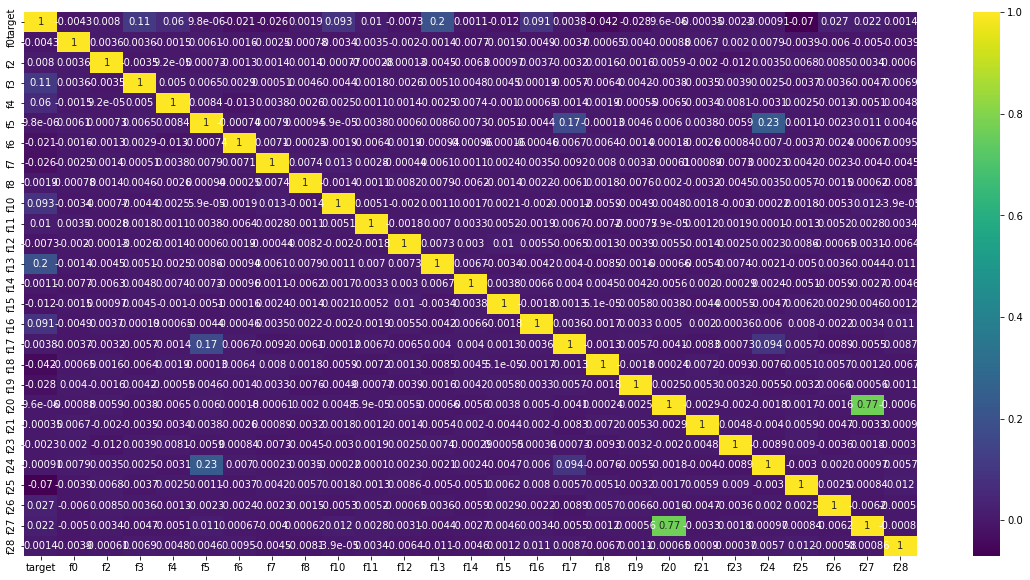

In [324]:
# Correlation plot
correlation = encoded_training_data.corr()
sns.heatmap(correlation, annot=True, cmap='viridis')

f20 and f27 have a very high correlation, which might indicate that one of them could be dropped for generality.  
We will do some feature pair plots to look for further patterns.

In [325]:
# Take a look at the five most correlated feature pairs
keep = np.triu(np.ones(correlation.shape), k=1).astype('bool').reshape(correlation.size)
correlation = correlation.abs().stack()[keep]  # Only use the lower triangular part of the correlation matrix
correlation = correlation.sort_values(ascending=False)[0:5]  # Only keep top 5
correlation = pd.DataFrame(correlation)
print('The five most correlated features:', correlation)

The five most correlated features:                    0
f20    f27  0.769427
f5     f24  0.231562
target f13  0.200793
f5     f17  0.171035
target f3   0.109885


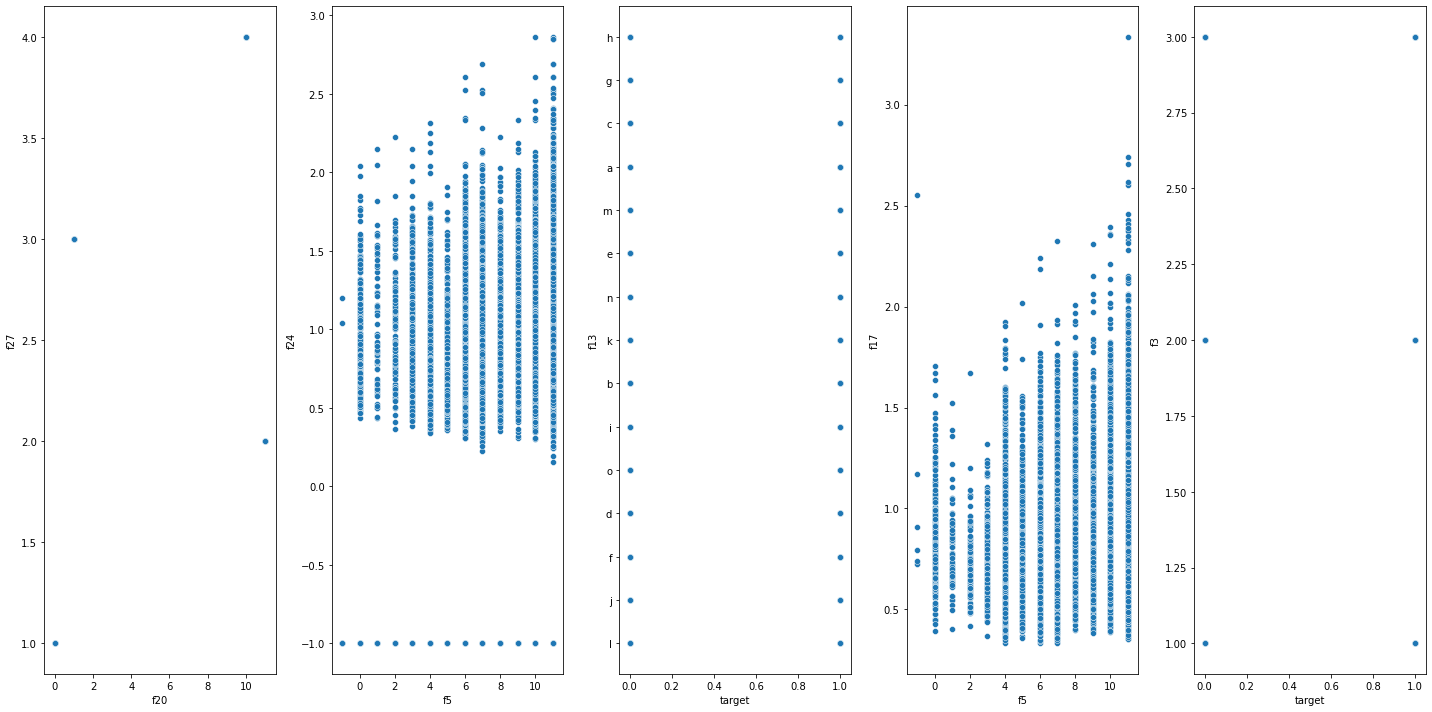

In [326]:
fig, axes = plt.subplots(1, len(correlation))

for i, (feature_x, feature_y) in enumerate(correlation.index):
    ax = sns.scatterplot(data=training_data, x=feature_x, y=feature_y, ax=axes[i])

plt.tight_layout()
plt.show()

The correlation plot shows that **f20** and **f27** have a very high correlation. One of these could be dropped to increase generality (and reduce the computational cost). 

The feature pairs (**f5**, **f24**) and (**f5**, **f17**) tend to increase together
We can also see that the features **f3** and **f16** have a higher correlation with the target value than others, and that we should probably focus our efforts on these.

# Data cleaning
Data cleaning consists of the following steps
- Removal of unwanted observations
- Fixing structural errors
- Managing unwanted outliers
- Handeling missing data

In [327]:
# Duplicate detection
training_data.duplicated().sum(axis = 0)

0

No duplicate rows in the data set, so no need to remove any rows either.

## Outlier detection and removal

The IQR method is used in this project for outlier detection and removal.  

We decided to only use the interval features (f11, f17, f24, and f28) for outlier detection and removal.  
This is because these features are numerical, have many unique values, and they all follow a clear distribution.  

The next feature with the most unique values after f24 is **f8**, which is a categorical feature (and have a lot fewer unique values): 

In [328]:
# Show the features with the most categories
summary_statistics['categories'].sort_values(ascending=False)[0:5]

f17    19209
f28     8060
f11     7633
f24     4148
f8      2177
Name: categories, dtype: int64

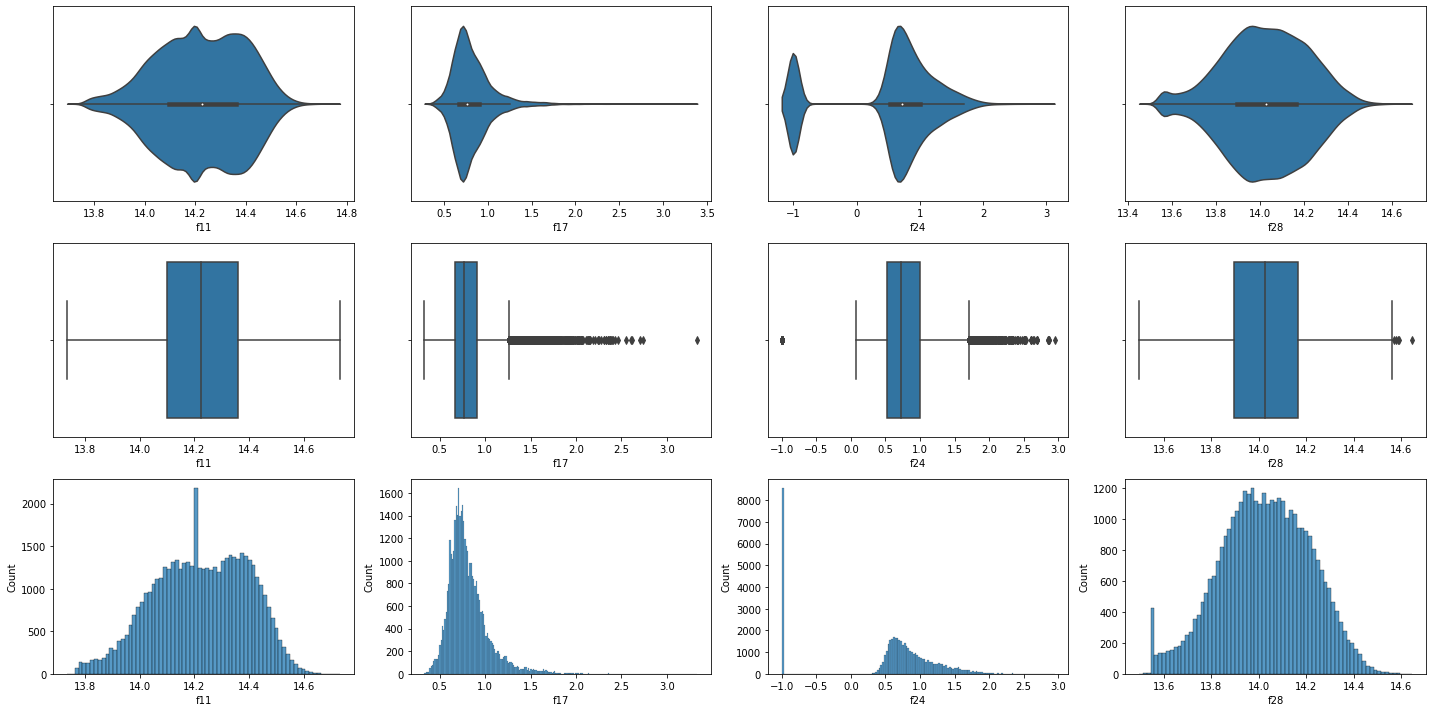

In [329]:
# Plot violin plot, box plot and histogram to show the distributions and highlight outliers
interval_features = ['f11', 'f17', 'f24', 'f28']
fig, axes = plt.subplots(3, len(interval_features))

for i, feature in enumerate(interval_features):
    ax = sns.violinplot(x=training_data[feature], ax=axes[0][i])
    ax = sns.boxplot(x=training_data[feature], ax=axes[1][i])
    ax = sns.histplot(training_data[feature], ax=axes[2][i])

fig.tight_layout()
plt.show()

In [330]:
# Outlier removal by interquartile range (IQR) method
Q1 = training_data[interval_features].quantile(0.25)
Q3 = training_data[interval_features].quantile(0.75)
IQR = Q3 - Q1

# Only remove the "right tail" from the features to keep the -1 value
initial_row_count = training_data.shape[0]
training_data = training_data[~(training_data > (Q3 + 1.5 * IQR)).any(axis=1)]
encoded_training_data = encoded_training_data[~(encoded_training_data > (Q3 + 1.5 * IQR)).any(axis=1)]  # Also do this step for the encoded data
rows_removed = initial_row_count - training_data.shape[0]
print(f'Rows removed: {rows_removed}')

Rows removed: 2703


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


## Dealing with missing values

Different predictors have different schemes for handling missing data.  
In this project we have focused on XGBoost and CatBoost primarily.

XGBoost and CatBoost missing values are handled separately before training.
- XGBoost: missing values should be zero
- CatBoost: missing values should be way off the distribution, -999 seems to be a popular choice

## Partition the data into the convectional 'X' and 'y'

In [331]:
# Partition the data
X = training_data.drop(columns=['target']).copy()
X_encoded = encoded_training_data.drop(columns=['target']).copy()

y = training_data[['target']].copy()

# Model Choice and Training

## Utility functions

Useful functions for converting back and forth between feature names (e.g. 'f10') to indices (e.g. 10) and recomputing these if any features has been dropped.

In [332]:
# Utility function to go from, e.g. 'f10' to 10
def features_to_indices(features):
    return [int(column.replace('f', '')) for column in features]

In [333]:
# Utility function to go from, e.g. 10 to 'f10
def indices_to_features(indices):
    return [f'f{index}' for index in indices]

In [334]:
# Utility function for computing the new indices after dropping certain columns
def indices_after_droping(indices, dropped_columns):
    updated_indices = list(indices)
    dropped_indices = features_to_indices(dropped_columns)
    
    for i, old_index in enumerate(indices):
        for column_index in dropped_indices:
            if old_index >= column_index:
                updated_indices[i] -= 1

    return updated_indices

## CatBoost

CatBoost expects missing values to be set to a value which is clearly off the distribution of the feature. -999 seems to be a normal choice.  
CatBoost also expects categorical data to be strings. The indices of these also needs to be specified.

### CatBoost specific preprocessing

In [347]:
# CatBoost specific preprocessing

# Imputing
fill_value = -999 

# Make new data sets for CatBoost
X_catboost = X.fillna(fill_value)
X_test_catboost = X_test.fillna(fill_value)

X_encoded_catboost = X_encoded.fillna(fill_value)
X_encoded_test_catboost = X_test_encoded.fillna(fill_value)

missing_values = pd.DataFrame(
    {
        '#nan_train': X_catboost.isnull().sum(axis = 0),
        '#nan_test': X_test_catboost.isnull().sum(axis = 0),
    }, 
    index=X_catboost.columns,
)

# Check if there are any missing values left
print(missing_values)

     #nan_train  #nan_test
f0            0          0
f1            0          0
f2            0          0
f3            0          0
f4            0          0
f5            0          0
f6            0          0
f7            0          0
f8            0          0
f9            0          0
f10           0          0
f11           0          0
f12           0          0
f13           0          0
f14           0          0
f15           0          0
f16           0          0
f17           0          0
f18           0          0
f19           0          0
f20           0          0
f21           0          0
f22           0          0
f23           0          0
f24           0          0
f25           0          0
f26           0          0
f27           0          0
f28           0          0


In [348]:
# Converting numerical features to categorical / "strings"
categorical_numerical_features = ['f0', 'f6', 'f20']

X_catboost[categorical_numerical_features] = X_catboost[categorical_numerical_features].astype(str)

X_test_catboost[categorical_numerical_features] = X_test_catboost[categorical_numerical_features].astype(str)

# f5 and f28 have many missing values and could be dropped for generality
catboost_dropped_features = ['f13']
X_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_test_catboost.drop(catboost_dropped_features, axis=1, inplace=True)

X_encoded_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_encoded_test_catboost.drop(catboost_dropped_features, axis=1, inplace=True)

In [349]:
categorical_features_indices = [0, 1, 6, 9, 22]
categorical_features_indices += features_to_indices([*hexadecimal_features, *alphabetic_features, *binary_features, *boolean_features])

categorical_features_indices = sorted(categorical_features_indices)
print('Categorical features:', categorical_features_indices)

Categorical features: [0, 1, 2, 4, 6, 8, 9, 10, 12, 13, 14, 15, 18, 20, 22, 23, 25, 26]


### Training CatBoost

In [351]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_catboost, y, train_size=0.8, random_state=42)

catboost_dropped_indices = features_to_indices(catboost_dropped_features)
categorical_features_indices = [index for index in categorical_features_indices if index not in catboost_dropped_indices]
categorical_features_indices_after_dropping = indices_after_droping(categorical_features_indices, catboost_dropped_features)
print('Categorical features after dropping:', categorical_features_indices_after_dropping)

catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

catboost_model.fit(
    X_catboost, y,
    cat_features=categorical_features_indices_after_dropping
)

Categorical features after dropping: [0, 1, 2, 4, 6, 8, 9, 10, 12, 13, 14, 17, 19, 21, 22, 24, 25]


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

CatBoost classifier accuracy: 82.94%
CatBoost classifier log loss: 39.02%


<AxesSubplot:xlabel='feature_importance'>

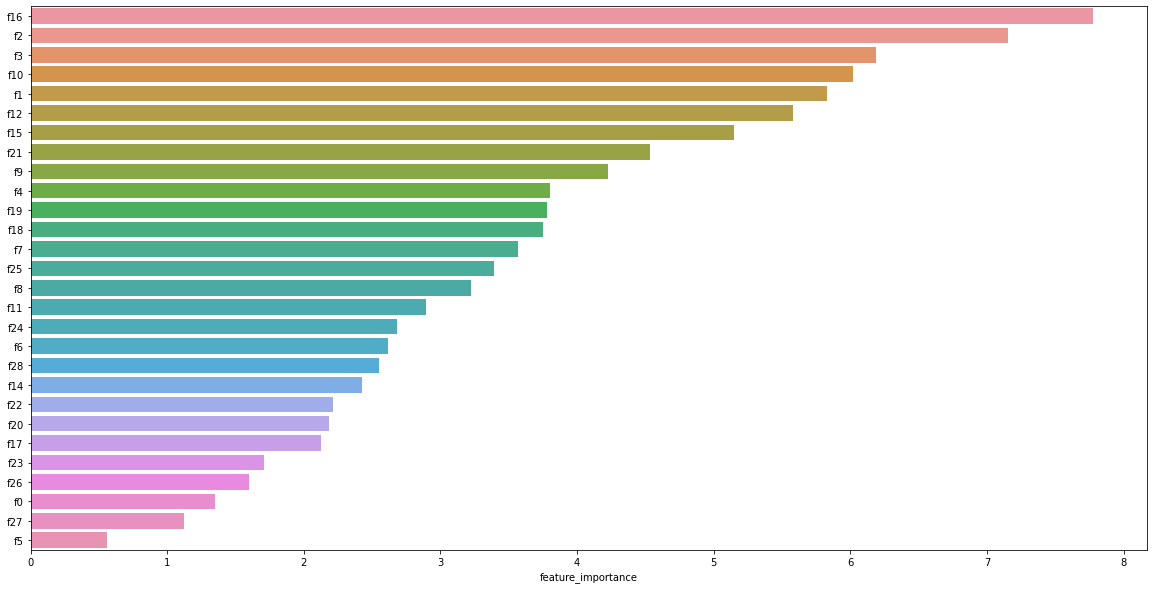

In [ ]:
(_, accuracy), (_, log_loss) = catboost_model.get_best_score()['learn'].items()
print(f'CatBoost classifier accuracy: {accuracy * 100:.2f}%')
print(f'CatBoost classifier log loss: {log_loss * 100:.2f}%')

feature_importance = pd.DataFrame({'feature_importance': catboost_model.get_feature_importance()}, index=X_catboost.columns)
feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(data=feature_importance, x='feature_importance', y=feature_importance.index)

### Training CatBoost regressor

We would like to se if using regression instead of classification could be beneficial.

In [ ]:
catboost_regressor = CatBoostRegressor(
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

catboost_regressor.fit(
    X_catboost, y,
    cat_features=categorical_features_indices_after_dropping,
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

CatBoost regressor RMSE: 35.04%


<AxesSubplot:xlabel='feature_importance'>

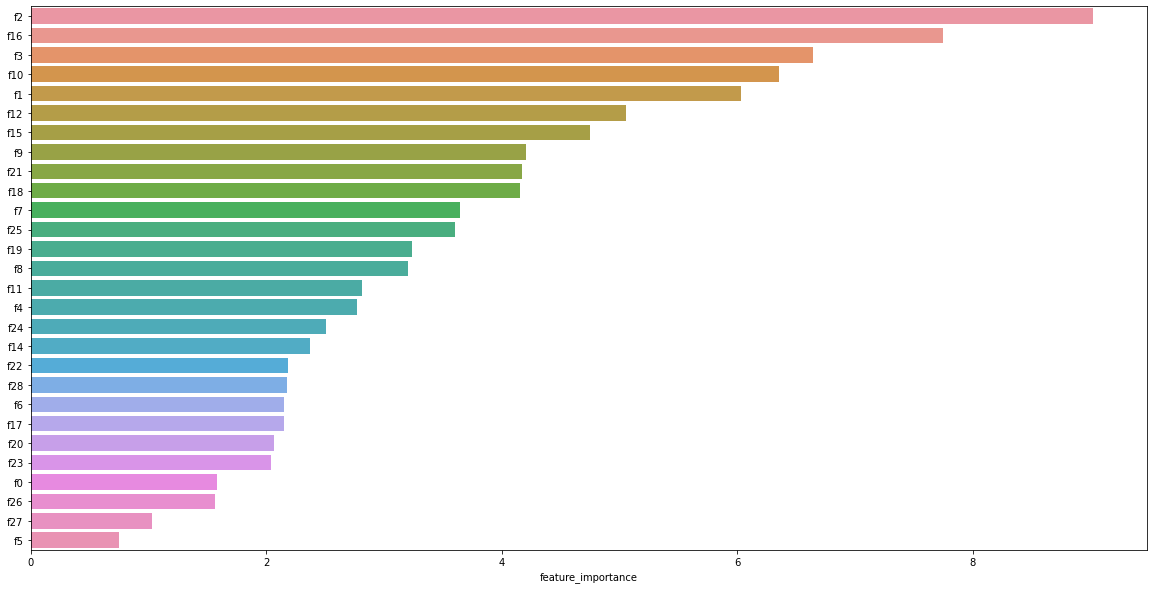

In [ ]:
RMSE = catboost_regressor.get_best_score()['learn']['RMSE']
print(f'CatBoost regressor RMSE: {RMSE * 100:.2f}%')

feature_importance = pd.DataFrame({'feature_importance': catboost_regressor.get_feature_importance()}, index=X_catboost.columns)
feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(data=feature_importance, x='feature_importance', y=feature_importance.index)

## XGBoost

XGBoost expects all features to be numerical, as opposed to CatBoost which requires categorical features to be strings.  
We use one-hot encoding for the categorical features which has not been converted to numbers in any prior preprocessing steps.

In [ ]:
# XGBoost specific preprocessing
categorical_features = indices_to_features(categorical_features_indices)
print(categorical_features_indices)

# One-hot encode all categorical features
X_xgboost = pd.get_dummies(X, columns=categorical_features)
X_test_xgboost = pd.get_dummies(X_test, columns=categorical_features)

### Training XGBoost

In [ ]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_xgboost, y)

predictions = xgboost_model.predict(X_xgboost)
accuracy = accuracy_score(y, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

## Stacking

We try to stack the regular CatBoost classifier, the encoded CatBoost classifier and XGBoost together to see if we can improve.

In [366]:
def fold_train(model, X, y, k_fold=KFold(n_splits=10)):
	print(f'Training model: {model.__class__.__name__} with {k_fold.get_n_splits()} splits.')
	print(X.head())

	targets = pd.DataFrame(columns=['target'])
	predictions = pd.DataFrame(columns=['target'])

	for train_ix, test_ix in k_fold.split(X):	
		train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
		train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

		model.fit(train_X, train_y)

		prediction = model.predict(test_X, prediction_type='Probability')[:,1]

		targets = targets.append(test_y)
		predictions = predictions.append(pd.DataFrame(prediction, columns=['target']), ignore_index=True)

	return targets, predictions

In [367]:
categorical_features_indices_encoded = [1, 9, 22]

print('Categorical features (encoded):', categorical_features_indices_encoded)


catboost_dropped_indices = features_to_indices(catboost_dropped_features)
categorical_features_indices_encoded = [index for index in categorical_features_indices_encoded if index not in catboost_dropped_indices]
categorical_features_indices_encoded_after_dropping = indices_after_droping(categorical_features_indices_encoded, catboost_dropped_features)

categorical_features_indices = sorted(categorical_features_indices_encoded_after_dropping)
print('Categorical features after dropping (encoded):', categorical_features_indices_encoded_after_dropping)

Categorical features (encoded): [1, 9, 22]
Categorical features after dropping (encoded): [1, 9, 21]


In [ ]:
# Stacking several CatBoosts together
columns = ['cb_normal', 'cb_encoded', 'xgb']
predictions = pd.DataFrame(columns=columns)

k_fold = KFold(n_splits=10)

models = [
    CatBoostClassifier(
        cat_features=categorical_features_indices_encoded_after_dropping,
        random_seed=RANDOM_SEED,
        logging_level='Silent'
    ),
    CatBoostClassifier(
        cat_features=categorical_features_indices_after_dropping,
        random_seed=RANDOM_SEED,
        logging_level='Silent'
    ),
    # XGBClassifier()
]

data_sets = [
    X_encoded_catboost,
    X_catboost,
    # X_catboost,
    # X_xgboost
]

model_targets, model_predictions = list(map(list, zip(*[fold_train(model, data_set.head(10), y) for model, data_set in zip(models, data_sets)])))

print(model_targets, model_predictions)

# print(targets_1.to_numpy()[:,0])
# print(predictions_1.to_numpy()[:,0])

# 
# estimators = [
#     ('classifier_vanilla', CatBoostClassifier(
#         training_data=X_test_catboost,
#         cat_features=categorical_features_indices_after_dropping,
#         random_seed=RANDOM_SEED,
#         logging_level='Silent'
#     )),
#     ('classifier_encoded', CatBoostClassifier(
#         training_data=X_encoded_test_catboost,
#         cat_features=categorical_features_indices_after_dropping,
#         random_seed=RANDOM_SEED,
#         logging_level='Silent'
#     )),
# ]

# final_estimator = LogisticRegression()

# stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# stacking_model.fit(X_catboost, y)

# accuracy = stacking_model.score(X_catboost, y)
# print(f'Stacking accuracy: {accuracy * 100:.2f}%')

## Model Choice

Based on the results above, we choose to go forth with **CatBoost** as our main predictor.

## Hyperparameter tuning (CatBoost)
It is important to do hyperparameter tuning when training a machine learning model as these can have a great impact on both training time and accuracy. Doing proper hyperparameter tuning can help avoid local minima/maxima in both accuracy and loss. 

We attempted to avoid overfitting the model by using earlystopping and a validation dataset. Earlystopping is a technique wherein the model is tested on some unseen validation data continuously during training. The model is not trained on the validation data, and thus it is possible to identify when the model stops being more accurate for _unseen_ data, even though it may still be improving for the data it is itself trained on. A technique that often performs better than this however, is to use K-fold cross validation, the model switches between what data is used as training and validation data continuously, in order to utilize more of the available data for training.

For the CatBoost predictor, we therefore use a randomized search with cross-validation in order to try to find some "areas" of potential optimal settings.  
There are very many potential hyperparameters that can be tuned, but we have decided to focus only on those who have been considered the most important in other similar experiments.

In [ ]:
# List all parameters for CatBoost classifier
CatBoostClassifier?

In [ ]:
catboost_model = CatBoostClassifier(
    cat_features=categorical_features_indices_after_dropping,
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

hyperparameters = {
    'iterations': [80, 100, 120, 140, 160],
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 1.5, 2, 2.5, 3]
}

catboost_hyperparameters = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=hyperparameters, 
    n_iter=30, 
    scoring='accuracy',
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1,
    return_train_score=True
)

catboost_hyperparameters.fit(X_catboost, y)

We then list what hyperparameters gave the best results in the randomized search:

In [ ]:
catboost_hyperparameters.best_params_

# Predictions

Make predictions from `X_test_catboost` (test data transformed for CatBoost) and save to file.

In [ ]:
# CatBoost
y_pred = catboost_model.predict(X_test_catboost, prediction_type='Probability')
predictions = pd.DataFrame({'id': X_test_catboost.index, 'target': y_pred[:,1]})

predictions.to_csv('../output/catboost.txt', index=False)


# # XGBoost
# y_pred = xgboost_model.predict_proba(X_test_xgboost)
# predictions = pd.DataFrame({'id': X_test_xgboost.index, 'target': y_pred[:,1]})

# predictions.to_csv('../output/xgboost.txt', index=False)

Even though we tried to do hyperparameter tuning, we could unfortunately not identify any particular configuration of hyperparameters in our search that performed any better than the default parameters that Catboost chooses out of the box. We therefore decided to use only out of the box configurations for Catboost, as any further attempts to improve the model with typical techniques only worsened the model.

# Model interpretation

### SHAP values / feature importance
In order to explain the model, we are using a SHapley Additive exPlanations (SHAP) plot to assign an importance value to each feature for a given prediction. By using a summarizing plot for all features, we obtain a feature importance plot. In this plot, red values represent an increase in feature value while blue values represent a decrease. When a value has a negative SHAP value (to the left of 0.0) this represents a decrease in target value, while a positive SHAP value represents an increase in target value

In [ ]:
sorted_feature_importance = catboost_model.get_feature_importance()
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

Most of the features in the dataset are gray in this plot, as they are not numeric features with defined «high» and «low» values. Some of them, like f13, could be converted to numeric in order to get an ordinal property and thus get further information (through coloring) in this plot. However, in the feature engineering phase, ww discovered that converting these properties to numeric only worsened the accuracy of the model, and this is therefore left out of this plot as well.

### Confusion matrix

In [ ]:
ConfusionMatrixDisplay.from_estimator(catboost_model, X, y)
plt.show()

By observing the output of the confusion matrix, we can conclude with some findings:
The model mostly predicts the correct value for rows with a 0 as the target, with only a marginal amount of erros. For rows with 1 a the target however, the model actually has an error rate of almost 80%. This is not that surprising as the dataset is very imbalanced, with a 80/20 split of 0 and 1 valued targets respectively, as we identified in the EDA section. 

# TODO: things that should be cleaned up / removed:

In [ ]:
#shap.dependence_plot("f2", shap_values, X_catboost)

In [ ]:
# # confusion matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay